# Variational Autoencoder (VAE)

In [1]:
from toolbox import format_time, showLoss, showLatent, showInterpolation
from torch.nn.functional import binary_cross_entropy as BCE
from torchvision.datasets import MNIST, FashionMNIST
from model import VAE_Linear, VAE_Conv2d
from torchsummary import summary
from tqdm.notebook import trange
from torch.optim import RMSprop
from functools import partial
from torch import nn, Tensor
from time import time
import numpy as np
import torch as tr

## Enabling cuda acceleration

In [2]:
assert tr.cuda.is_available(), "CUDA is strongly recommanded, otherwise change value of device to 'cpu'"
device = tr.device('cuda')
tr.manual_seed(1972)
pass

## Loading and preprocessing data

$\large{X = \{x^1, x^2, \cdots, x^n\} }$

$\large{||X|| = (n,c,w,h)}$

- $n$ is the number of samples
- $c$ is the number of channels (1 $\rightarrow$ grayscale or 3 $\rightarrow$ RGB)
- $w$ is the width (in pixels) of the image
- $h$ is the height (in pixels) of the image

Color range has been normalized from $[0, 255]$ to $[0,1]$

For MNIST :

$\large{Y = \{0, \cdots, 9\}}$

$\large{||Y|| = n}$

### MNIST / Fashion MNIST

In [3]:
if True:
    train, test = MNIST('./data', True, download = True), MNIST('./data', False)
    # train, test = FashionMNIST('./data', True, download = True), FashionMNIST('./data', False)
    
    transform = lambda im: im.type(tr.float32).reshape(im.shape[0], 1, 28, 28) / 255.0
    X_train, y_train, X_test, y_test = transform(train.data), train.targets, transform(test.data), test.targets
    del train, test, transform
    
    print("min_width", min_width := 7)
    print("nb_layers", nb_layers := 3)
    print("on_device", on_device := True)

min_width 7
nb_layers 3
on_device True


### Other dataset

In [4]:
if False:
    dataset_name = "cifar10"
    tl = lambda file_name: tr.load(f"/mnt/e/datasets/_binary/{dataset_name}/{file_name}.pt")
    X_train, X_test, y_train, y_test = tl("train_fl"), tl("test_fl"), tl("train_y"), tl("test_y")

    print("min_width", min_width := 4)
    print("nb_layers", nb_layers := 4)
    print("on_device", on_device := True)

## Hyper-parameters

In [5]:
old_shape = X_train.shape
output_shape = np.asarray((*old_shape[2:], old_shape[1]))
assert min_width * 2**(nb_layers -1) == output_shape[0], "Incorrect min_width & nb_layers settings"
input_dim = output_shape.prod()
if on_device:
    X_train, X_test = X_train.to(device), X_test.to(device)

print("batch_size", batch_size := 2**6)
print("lr", lr := 1e-3)
print("is_linear", is_linear := False)
if is_linear:
    X_train, X_test = X_train.view(X_train.size(0), input_dim), X_test.view(X_test.size(0), input_dim)
else:
    print("kernel_size", kernel_size := 5)

print("min_weight", min_weight := 6)
# Growing number of features/weights
print("weights", weights := [2**i for i in range(min_weight, min_weight + nb_layers)])
# Static number of features/weights
# print("weights", weights := [2**min_weight for i in range(nb_layers)])

if is_linear:
    print(f"||X|| = {old_shape} input_dim: {input_dim}")
else:
    print(f"||X|| = {old_shape} output_shape: {output_shape}")

batch_size 64
lr 0.001
is_linear False
kernel_size 5
min_weight 6
weights [64, 128, 256]
||X|| = torch.Size([60000, 1, 28, 28]) output_shape: [28 28  1]


## Building model

### Probabilistic encoder

$\large{q_\phi(Z|X)}$

#### Reparametrization trick

$\large{z = \mu + \sigma \odot \epsilon}$

$\large{\epsilon \sim \mathcal{N}(\mu_x, \sigma_x)}$

In [6]:
def reparameterize(mu: Tensor, log_var: Tensor) -> Tensor:
    std = log_var.mul(0.5).exp_()
    eps = std.data.new(std.size()).normal_()
    return eps.mul(std).add_(mu)

### Probabilistic decoder

$\large{\mathcal{p}_\theta(X|Z)}$

## Criterion (loss function)

$$\large{\mathcal{L_{VAE}}(\theta,\phi) = D_{KL}(q_\phi(Z|X)||p_\theta(Z|X))}$$

Because $\large{D_{KL}(A||B)}$ = $\large{\int\limits_{-\infty}^\infty A(x) \cdot log\frac{A(x)}{B(x)}dx}$

$$\large{= \int q_\phi(Z|X) \cdot log\frac{q_\phi(Z|X)}{p_\theta(Z|X)}dz}$$

Because $\large{p(Z|X) = \frac{p(Z,X)}{p(Z)}}$

$$\large{= \int q_\phi(Z|X) \cdot log\frac{q_\phi(Z|X) \cdot p_\theta(X)}{p_\theta(Z,X)}dz}$$

$$\large{= \int q_\phi(Z|X) \cdot [log(p_\theta(X) + log \frac{q_\phi(Z|X)}{p_\theta(Z,X)}]dz}$$

Because $\large{\int q(Z|X)dz=1}$

$$\large{= log[p_\theta(X)] + \int q_\phi(Z|X) \cdot log \frac{q_\phi(Z|X)}{p_\theta(Z,X)}dz}$$

$$\large{= log[p_\theta(X)] + \int q_\phi(Z|X) \cdot log \frac{q_\phi(Z|X)}{p_\theta(X|Z) \cdot p_\theta(Z)}dz}$$

Because $\large{p(z,x)=p(x|z) \cdot p(z)}$

$$\large{= log[p_\theta(X)] + E_{z\sim q_\phi(Z|X)}[log \frac{q_\phi(Z|X)}{p_\theta(Z)} - log(p_\theta(X|Z))]}$$

$$\large{= log[p_\theta(X)] + D_{KL}(q_\phi(Z|X)||p_\theta(Z))- E_{z\sim q_\phi(Z|X)} log[p_\theta(X|Z)]}$$

### Rearranging terms

$$\large{D_{KL}(q_\phi(Z|X)||p_\theta(Z|X)) = log[p_\theta(X)] + D_{KL}(q_\phi(Z|X)||p_\theta(Z))- E_{z\sim q_\phi(Z|X)} log[p_\theta(X|Z)]}$$

$$\large{log[p_\theta(X)] - D_{KL}(q_\phi(Z|X)||p_\theta(Z|X)) = E_{z\sim q_\phi(Z|X)} log[p_\theta(X|Z)] - D_{KL}(q_\phi(Z|X)||p_\theta(Z))}$$

The LHS of the equation is what we want to maximize when learning the true distributions, soo the negation of the above defines our loss function :

$$\large{\mathcal{L_{VAE}}(\theta,\phi) = - log[p_\theta(X)] + D_{KL}(q_\phi(Z|X)||p_\theta(Z|X))}$$

$$\large{ = - E_{z\sim q_\phi(Z|X)} log[p_\theta(X|Z)] + D_{KL}(q_\phi(Z|X)||p_\theta(Z))}$$

$$\large{\theta^*,\phi^* = argmin_{\theta,\phi}(\mathcal{L_{VAE}})}$$

### Final form (derived)

With

$$\large{BCE = - E_{z\sim q_\phi(Z|X)}[p_\theta(X|Z)]}$$

$$\large{\mathcal{L_{VAE}}(\theta,\phi) = BCE + D_{KL} (q_\phi(Z|X)||p_\theta(Z))}$$

In [7]:
def criterion(output: Tensor, mu: Tensor, log_var: Tensor, x_batch: Tensor,
              batch_size: Tensor, input_dim: np.array) -> Tensor:
    D_KL = -0.5 * tr.sum(1 + log_var - mu.pow(2) - log_var.exp())
    D_KL /= batch_size * input_dim
    return BCE(output, x_batch) + D_KL

## Creating the model

In [8]:
if is_linear:
    model = VAE_Linear(reparameterize, weights, device, input_dim = input_dim)
    summary(model, (1, input_dim))
else:
    model = VAE_Conv2d(reparameterize, weights, device, output_shape, kernel_size, min_width)
    summary(model, tuple(output_shape[::-1]))
optimizer = RMSprop(model.parameters(), lr)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
              ReLU-2           [-1, 64, 14, 14]               0
          Conv2d_R-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]         204,928
              ReLU-5            [-1, 128, 7, 7]               0
          Conv2d_R-6            [-1, 128, 7, 7]               0
            Conv2d-7            [-1, 256, 4, 4]         819,456
              ReLU-8            [-1, 256, 4, 4]               0
          Conv2d_R-9            [-1, 256, 4, 4]               0
          Flatten-10                 [-1, 4096]               0
           Linear-11                    [-1, 2]           8,194
           Linear-12                    [-1, 2]           8,194
           Linear-13                   [-1, 49]             147
             ReLU-14                   

## Training the model

In [9]:
def train(X_train: Tensor, X_test: Tensor, nb_epoch: int, show_loss_interval: int) -> np.array:
    hist = {f"{name}_loss": np.empty(nb_epoch, dtype = np.float32) for name in ["train", "test"]}
    last_time = time()
    total_time_spent = 0.0
    train_size, test_size = X_train.shape[0], X_test.shape[0]
    n_train_batches, n_test_batches = np.ceil(train_size / batch_size), np.ceil(test_size / batch_size)
    
    model.train()
    print("Begining of training")
    for epoch in trange(1, nb_epoch + 1, position = 0, desc = 'Epoch', leave = False):
        batch_loss = 0.0
        for batch_idx in trange(0, train_size, batch_size, position = 1, desc = 'Batch train', leave = False):
            X_batch = X_train[batch_idx : batch_idx + batch_size]
            if not on_device:
                X_batch = X_batch.to(device)
            model.zero_grad()
            output, mu, log_var = model(X_batch)
            loss = criterion(output, mu, log_var, X_batch, batch_size, input_dim)
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
            if not on_device:
                del X_batch

        hist["train_loss"][epoch - 1] = batch_loss / n_train_batches
        
        batch_loss = 0.0
        for batch_idx in trange(0, test_size, batch_size, position = 1, desc = 'Batch test', leave = False):
            X_batch = X_test[batch_idx : batch_idx + batch_size]
            if not on_device:
                X_batch = X_batch.to(device)
            output, mu, log_var = model(X_batch)
            loss = criterion(output, mu, log_var, X_batch, batch_size, input_dim)
            batch_loss += loss.item()
            if not on_device:
                del X_batch

        hist["test_loss"][epoch - 1] = batch_loss / n_test_batches

        if epoch % show_loss_interval == 0:
            time_spent = time() - last_time
            last_time += time_spent
            total_time_spent += time_spent
            print(f"Epoch {epoch:04d} == {hist['train_loss'][epoch - 1]:.5f}", end = " | ")
            print(f"{hist['test_loss'][epoch - 1]:.5f}", end = " - ")
            print(format_time(time_spent))

    print(f"Ending of training, spent {format_time(total_time_spent)} training")
    model.eval()
    return hist

In [10]:
from IPython.display import HTML
"""
    Dirty fix to hide JupyterLab's display bug of tqdm(leave = False)

    Source : https://github.com/jupyterlab/jupyterlab/issues/7354#issuecomment-1282893131
"""
HTML("""
<pre>Applying stylesheet</pre>
<style>
    .jp-OutputArea-child:has(.jp-OutputArea-prompt:empty) {
          padding: 0 !important;
    }
</style>""")

In [11]:
hist = train(X_train, X_test, 50, 1)

Begining of training


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0001 == 0.23783 | 0.21731 - 11s 679ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0002 == 0.20275 | 0.20518 - 11s 455ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0003 == 0.19619 | 0.20053 - 11s 462ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0004 == 0.19282 | 0.19809 - 11s 564ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0005 == 0.19054 | 0.19818 - 11s 484ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0006 == 0.18893 | 0.19495 - 11s 543ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0007 == 0.18762 | 0.19735 - 11s 665ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0008 == 0.18656 | 0.19138 - 11s 610ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0009 == 0.18560 | 0.19220 - 11s 699ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0010 == 0.18496 | 0.19676 - 11s 936ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0011 == 0.18435 | 0.19309 - 11s 209ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0012 == 0.18370 | 0.19095 - 11s 216ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0013 == 0.18329 | 0.19290 - 11s 195ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0014 == 0.18282 | 0.19136 - 11s 500ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0015 == 0.18233 | 0.19015 - 11s 774ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0016 == 0.18205 | 0.19104 - 11s 620ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0017 == 0.18163 | 0.18844 - 11s 324ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0018 == 0.18126 | 0.19289 - 11s 268ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0019 == 0.18095 | 0.18837 - 11s 413ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0020 == 0.18071 | 0.18816 - 11s 459ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0021 == 0.18033 | 0.18951 - 12s 55ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0022 == 0.18010 | 0.19389 - 11s 945ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0023 == 0.17994 | 0.18686 - 11s 192ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0024 == 0.17973 | 0.19329 - 11s 514ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0025 == 0.17947 | 0.18897 - 11s 524ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0026 == 0.17924 | 0.18812 - 11s 543ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0027 == 0.17910 | 0.18765 - 11s 524ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0028 == 0.17890 | 0.19004 - 11s 538ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0029 == 0.17876 | 0.18906 - 11s 527ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0030 == 0.17861 | 0.19055 - 11s 538ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0031 == 0.17845 | 0.18784 - 11s 657ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0032 == 0.17835 | 0.19096 - 11s 585ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0033 == 0.17812 | 0.18655 - 11s 972ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0034 == 0.17797 | 0.18815 - 11s 607ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0035 == 0.17785 | 0.18596 - 11s 633ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0036 == 0.17777 | 0.18732 - 11s 713ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0037 == 0.17762 | 0.18672 - 11s 552ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0038 == 0.17748 | 0.19087 - 11s 569ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0039 == 0.17737 | 0.19029 - 11s 547ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0040 == 0.17736 | 0.18701 - 11s 566ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0041 == 0.17721 | 0.19128 - 11s 562ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0042 == 0.17710 | 0.18792 - 11s 564ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0043 == 0.17702 | 0.18837 - 11s 652ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0044 == 0.17689 | 0.18731 - 11s 573ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0045 == 0.17680 | 0.18877 - 11s 551ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0046 == 0.17678 | 0.18709 - 11s 624ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0047 == 0.17670 | 0.18624 - 11s 908ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0048 == 0.17670 | 0.18652 - 11s 632ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0049 == 0.17638 | 0.18750 - 11s 609ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0050 == 0.17637 | 0.18514 - 11s 763ms
Ending of training, spent 9m 38s 841ms training


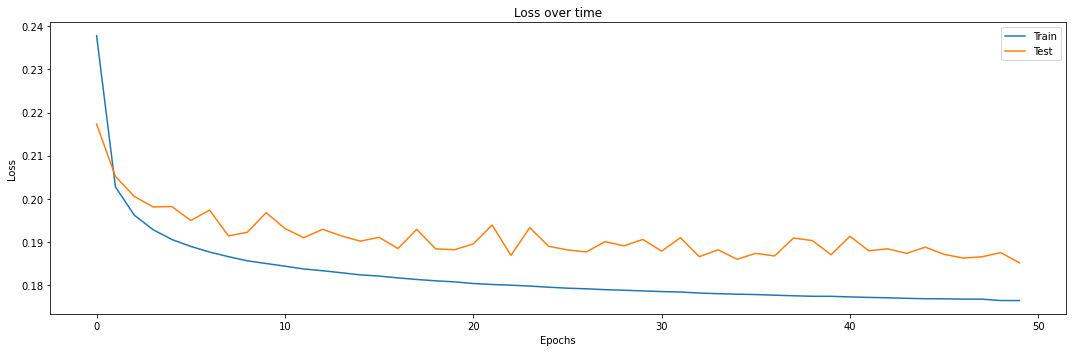

In [12]:
showLoss(hist)

## Latent space

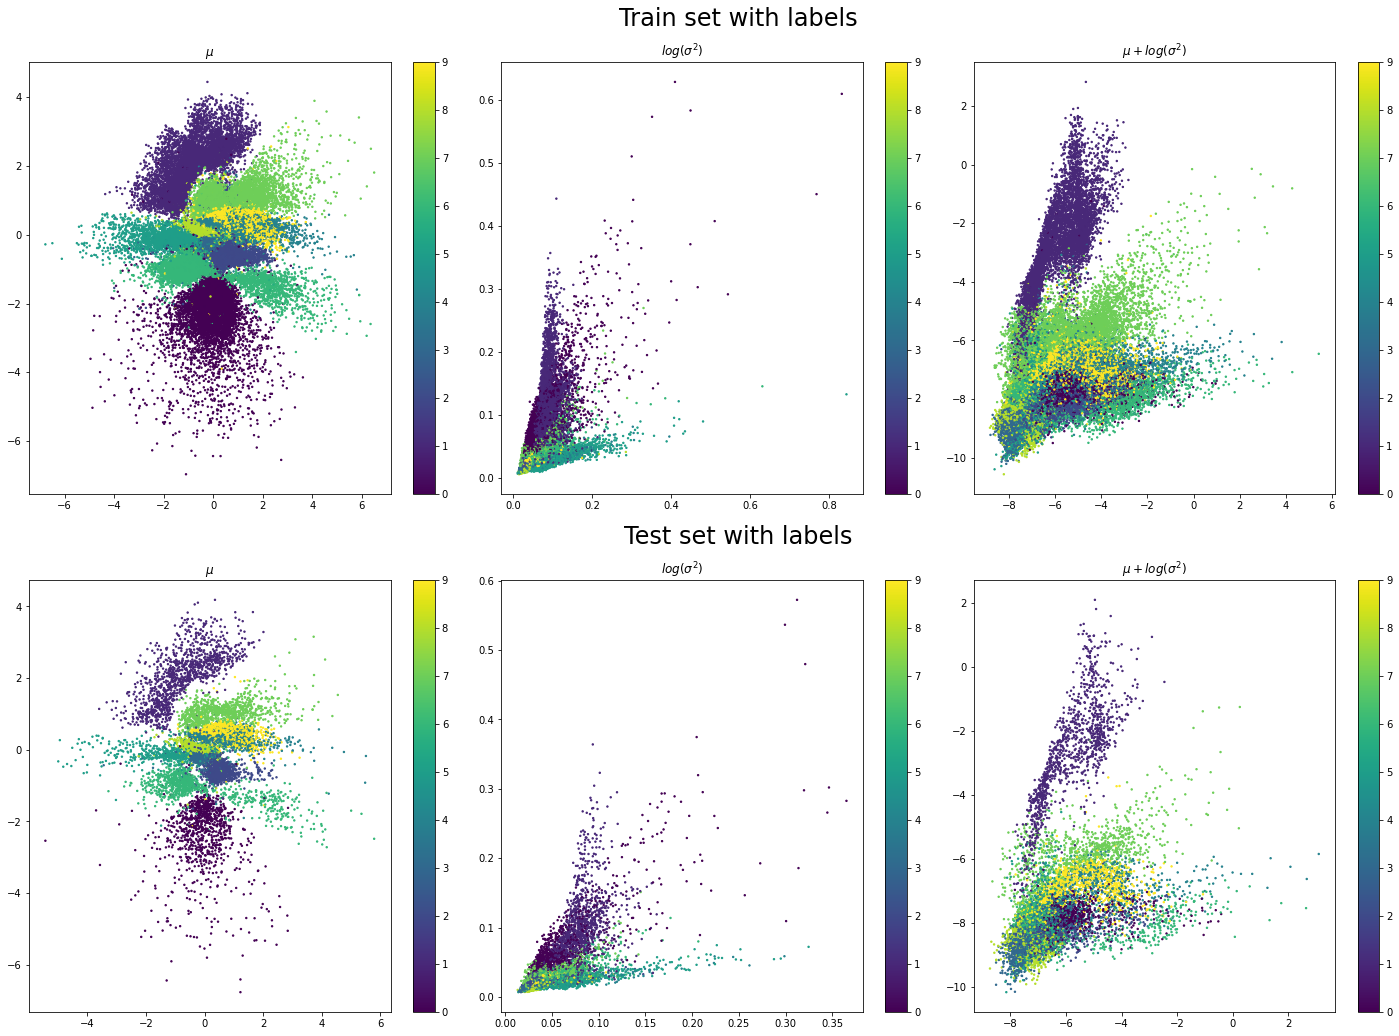

In [13]:
t_mu, t_log_var, t_mu_log_var = showLatent(model, X_train, X_test, batch_size, y_train, y_test,
                                           device if not on_device else None)

## Linear interpolation

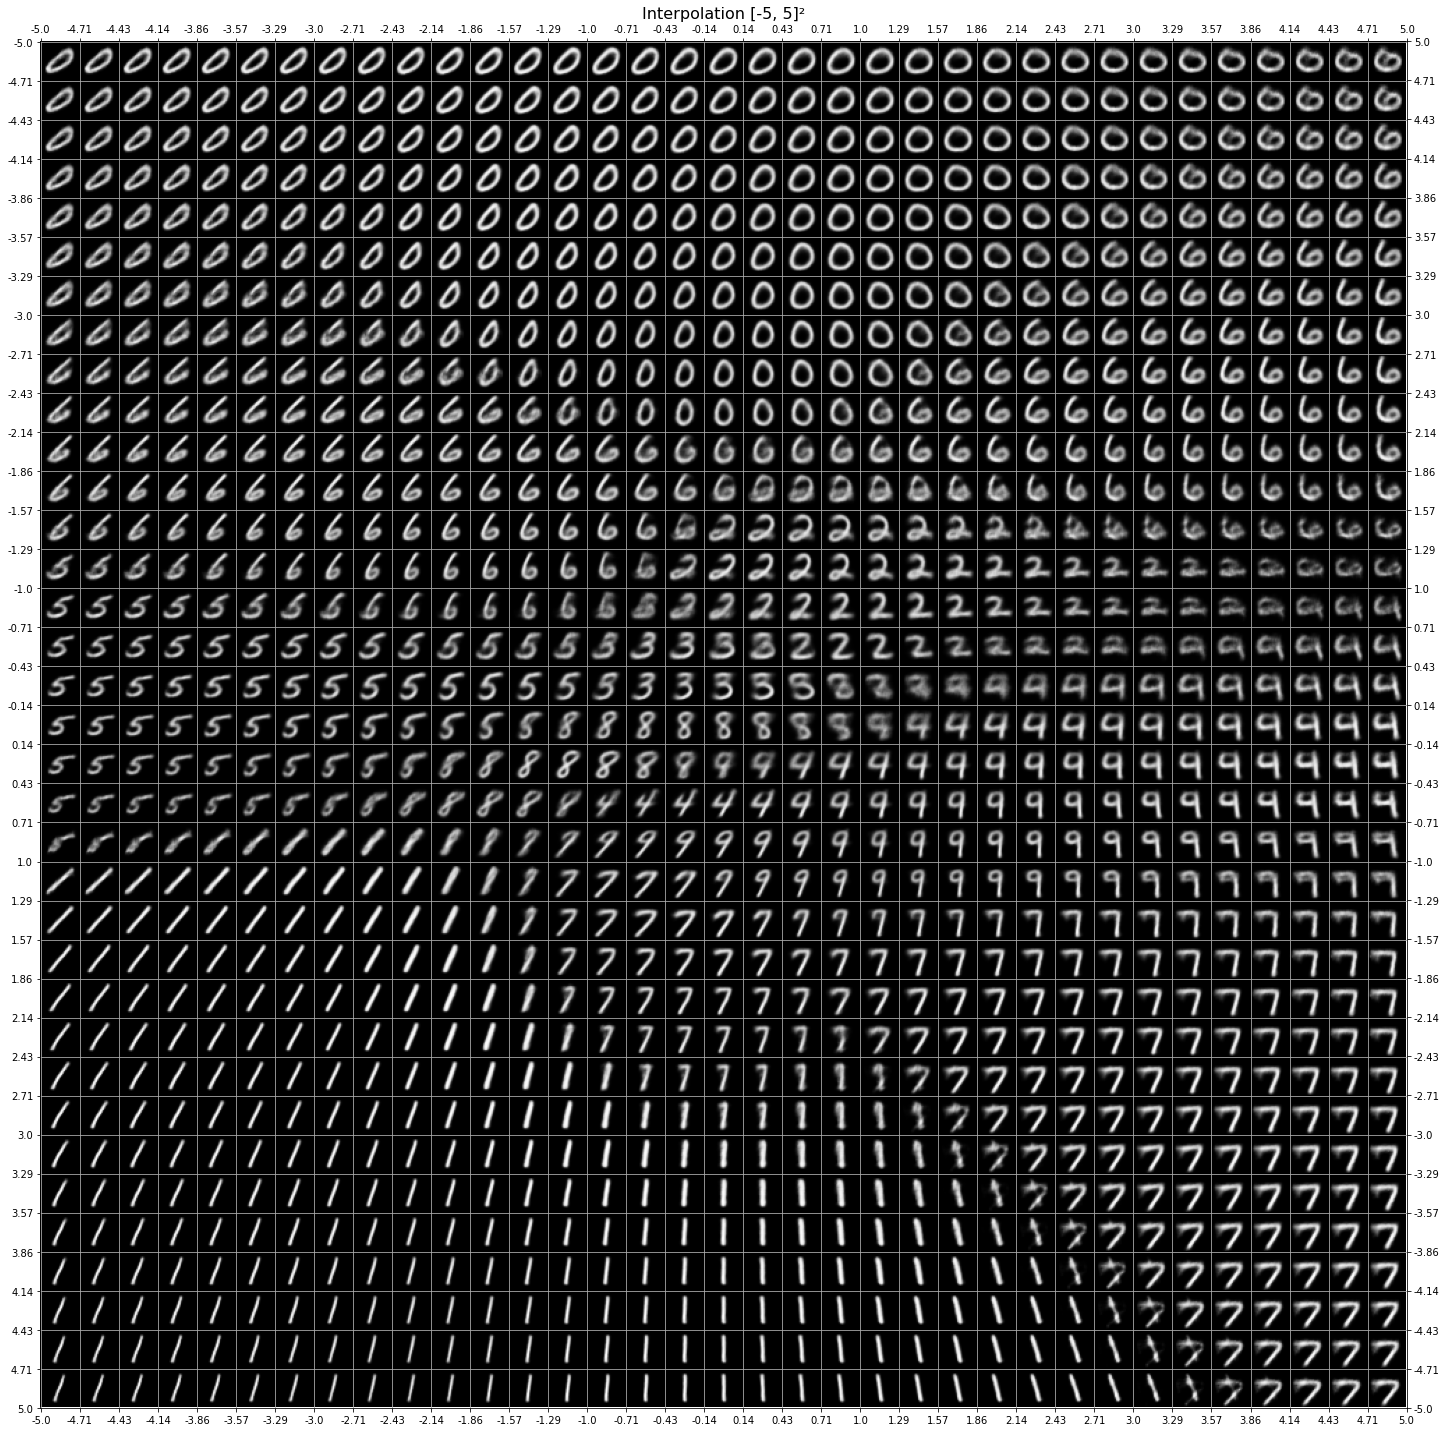

In [14]:
showInterpolation(model, output_shape, device, 35, (-5, 5))

_2021 Pierre Saunders @saundersp_